## Image Alteration Detection using Pretrained CNN (MobileNetV2)

#### Import libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import pandas as pd

#### Defining required parameters

In [4]:
# Parameters
IMG_SIZE = (128, 128)  # Smaller input for faster training
BATCH_SIZE = 32
EPOCHS = 10

# Paths
train_dir = 'dataset/train'  
test_dir = "dataset/test_mixed"
val_split = 0.2

#### Preparing data

In [5]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_split,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


#### Building Model using MobileNetV2

In [6]:
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights=None  # avoid automatic download
)
# the file is in the same directory
local_weights_file = os.path.abspath("mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5")
base_model.load_weights(local_weights_file)
base_model.trainable = False  # Freeze base

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Training model

In [7]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

C:\Users\Space Tech Computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 529ms/step - accuracy: 0.5004 - loss: 0.8326 - val_accuracy: 0.6075 - val_loss: 0.6607
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 497ms/step - accuracy: 0.6132 - loss: 0.6905 - val_accuracy: 0.6650 - val_loss: 0.6226
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step - accuracy: 0.6345 - loss: 0.6585 - val_accuracy: 0.6425 - val_loss: 0.6284
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 499ms/step - accuracy: 0.6495 - loss: 0.6441 - val_accuracy: 0.6625 - val_loss: 0.6248
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 512ms/step - accuracy: 0.6518 - loss: 0.6268 - val_accuracy: 0.7025 - val_loss: 0.5874
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 524ms/step - accuracy: 0.7034 - loss: 0.5790 - val_accuracy: 0.7050 - val_loss: 0.5938
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 537ms/step - accuracy: 0.6900 - loss: 0.5829 - val_accuracy: 0.7150 - val_loss: 0.5828
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 624ms/step - accuracy: 0.6923 - loss: 0.5819 - val_accu

#### Evaluating

In [8]:
val_data.reset()
preds = model.predict(val_data)
pred_classes = (preds > 0.5).astype("int32").flatten()
true_classes = val_data.classes

print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=["Fake", "Real"]))
print("Confusion Matrix:\n", confusion_matrix(true_classes, pred_classes))

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step
Classification Report:
               precision    recall  f1-score   support

        Fake       0.48      0.57      0.52       200
        Real       0.46      0.36      0.41       200

    accuracy                           0.47       400
   macro avg       0.47      0.47      0.46       400
weighted avg       0.47      0.47      0.46       400

Confusion Matrix:
 [[115  85]
 [127  73]]


#### Plot Training Curves

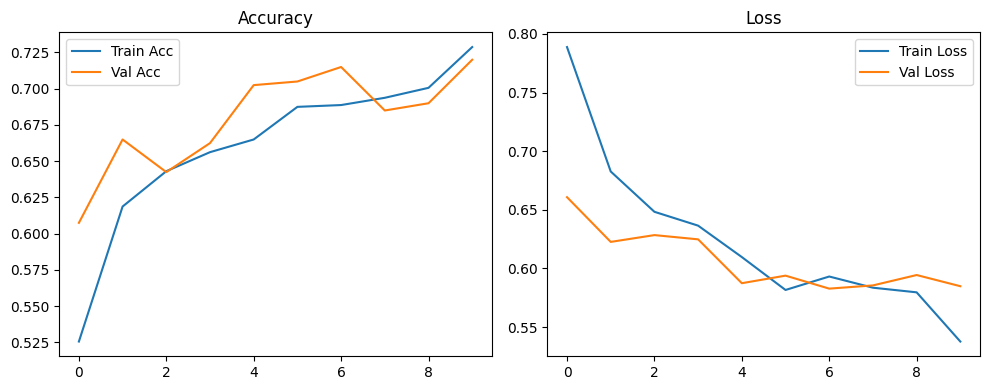

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.tight_layout()
plt.show()

#### Predicting model

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


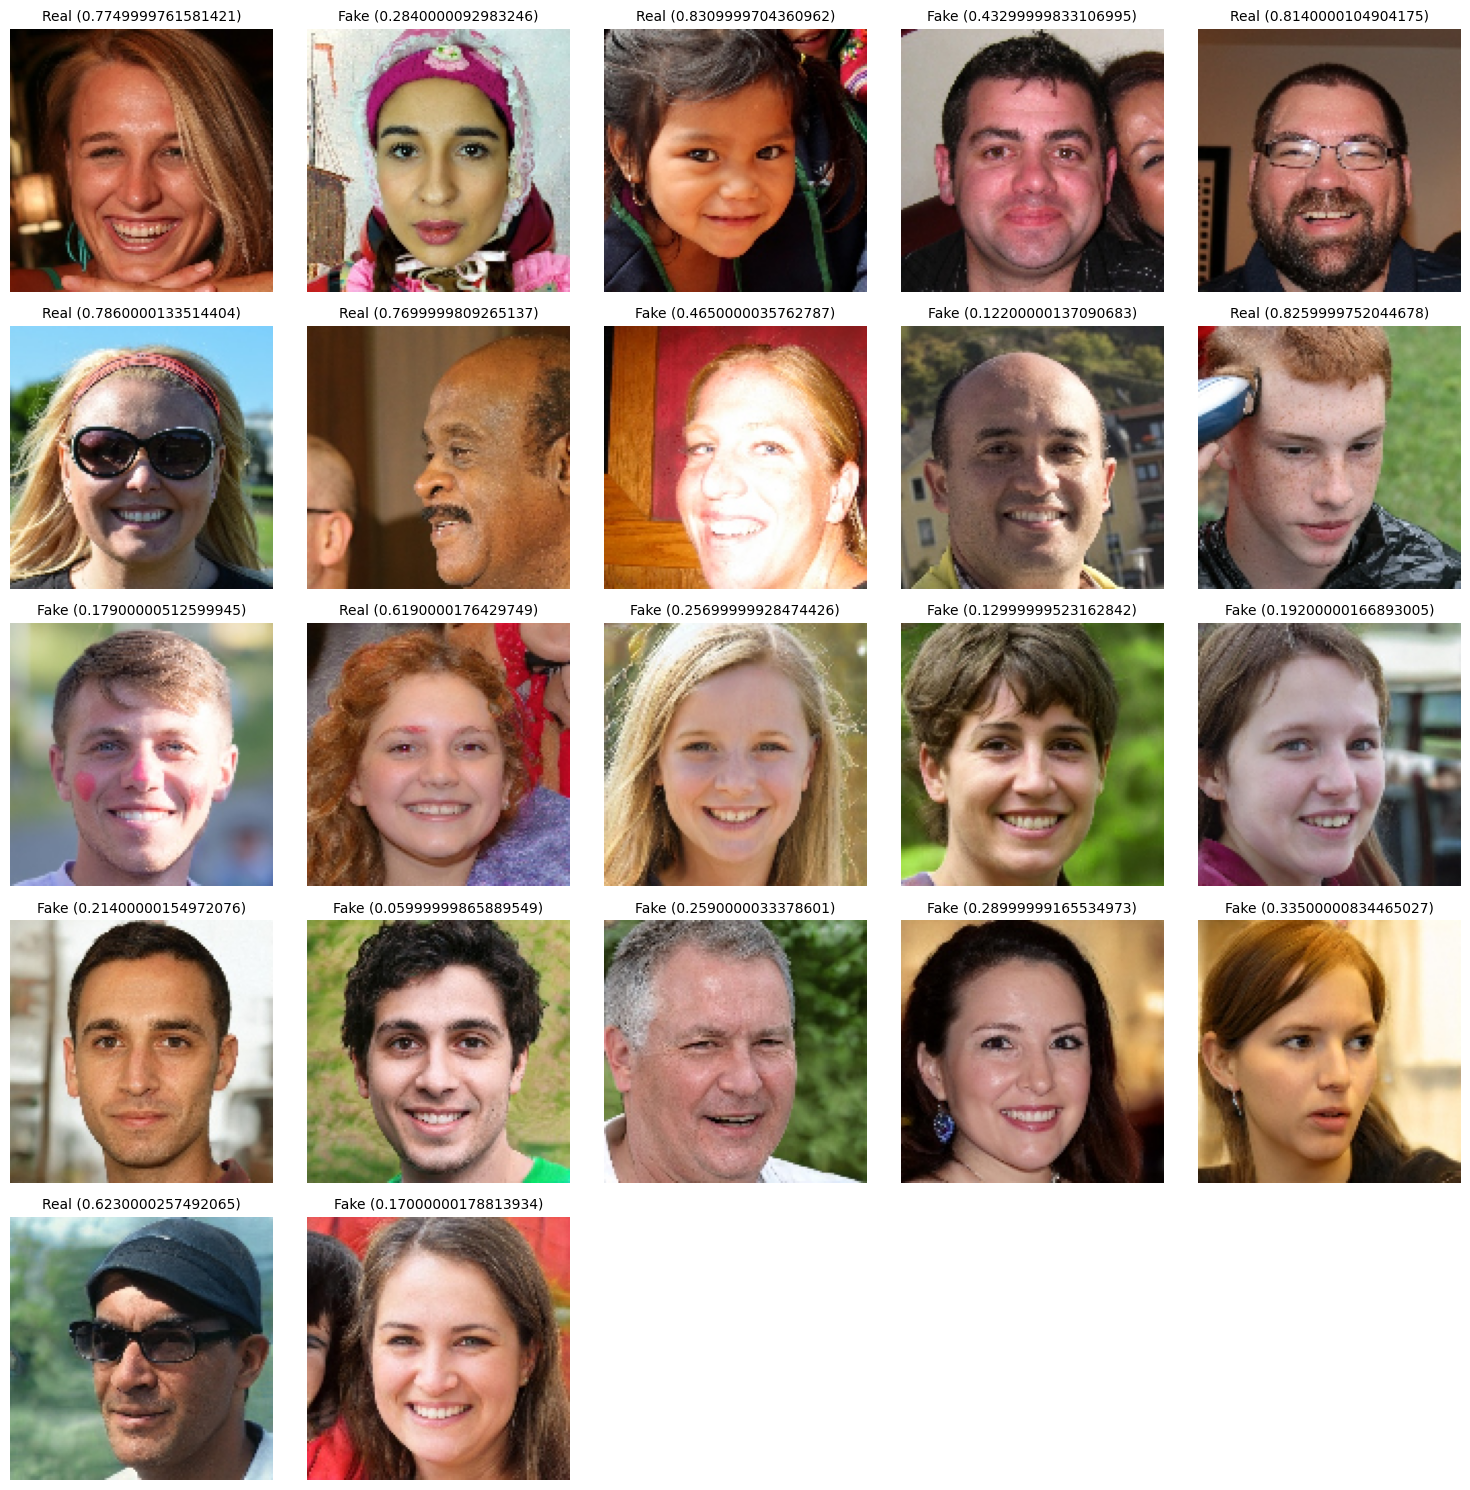

In [10]:
test_images = sorted(os.listdir(test_dir))  # Optional: sorted for consistent output

results = []

plt.figure(figsize=(15, 15))

for i, img_name in enumerate(test_images[:25]):  # Show first 25 predictions
    img_path = os.path.join(test_dir, img_name)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred = model.predict(img_array)[0][0]
    label = "Real" if pred >= 0.5 else "Fake"
    confidence = round(pred, 3)

    results.append({"filename": img_name, "prediction": label, "confidence": confidence})
    # Plot
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{label} ({confidence})", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Saving the result in .csv format

In [11]:
# Save predictions
df = pd.DataFrame(results)
df.to_csv("predictions_on_mixed_test.csv", index=False)
print("✅ Predictions saved to predictions_on_mixed_test.csv")

✅ Predictions saved to predictions_on_mixed_test.csv


#### Saving model

In [12]:
model.save('mobilenetv2_model.h5')
print("✅ Model saved to mobilenetv2_model.h5")

✅ Model saved to mobilenetv2_model.h5
